In [1]:
import psycopg2
import json
from datetime import datetime as dt
import pandas as pd
import re 
from textblob import TextBlob 

In [2]:
p="dataisok"

In [3]:
conn = psycopg2.connect(user = "sam",
                                  password = f"{p}",
                                  host = "127.0.0.1",
                                  port = "3306",
                                  database = "postgres")

In [4]:
cursor = conn.cursor()

In [5]:
tweet_list = []
followers = []
cursor.execute("select * from tweets")
tweets = cursor.fetchall()
if not tweets:
    print("empty")
for row in tweets:
    for col in row:
        if type(col) is dict:
            tweet_list.append(col['text'])
            followers.append(col['user']['followers_count'])

In [6]:
remove_list = [r'@[A-Za-z0-9]+','https?://[A-Za-z0-9./]+','\n','RT :',r'_[A-Za-z0-9]+','  ']

In [7]:
def clean_tweets(remove_list,tweet_list):
    for item in remove_list:
        tweet_list = [re.sub(item,'',tweet) for tweet in tweet_list]
    return tweet_list

In [8]:
cleaned = clean_tweets(remove_list,tweet_list)
len(cleaned)

2316

In [9]:
def result(tweet,keyword_list):
    if any(word in tweet for word in keyword_list):
        return 1
    else:
        return 0

In [10]:
sentiment = []
subjectivity= []
bernie = []
buttigieg = []
biden = []
warren = []
gender = []
age = []
democrat = []
socialist = []
trump = []
delegates = []
extended = []
length = []
for tweet in cleaned:
    tweet_length = len(tweet)
    length.append(tweet_length)
    if tweet_length > 140:
        extended.append(1)
    else:
        extended.append(0)
    delegates.append(result(tweet.lower(),["delegate","delegates"]))
    trump.append(result(tweet.lower(),["trump","donald","donald trump","donaldtrump","donald j. trump","don"]))
    socialist.append(result(tweet.lower(),["socialist","socialism","far-left","left-extremist", "extreme left"]))
    democrat.append(result(tweet.lower(),["democrat","democratic"]))
    age.append(result(tweet.lower(),["old","aging","grandpa"]))
    gender.append(result(tweet.lower(),["female","woman","girl","lady","women"]))
    warren.append(result(tweet.lower(),["warren",'elizabeth',"elizabethwarren","elizabeth warren"]))
    biden.append(result(tweet.lower(),["biden","joe","joebiden","joe biden"]))
    buttigieg.append(result(tweet.lower(),["buttigieg","pete","petebuttigieg","pete buttigieg"]))
    bernie.append(result(tweet.lower(),["bernie","berniesanders","sanders","bernie sanders", "feel the bern"]))
    sentiment.append([TextBlob(tweet).polarity])
    subjectivity.append([TextBlob(tweet).subjectivity])

In [11]:
data = pd.DataFrame({"bernie":bernie,"buttigieg":buttigieg,"biden":biden,"warren":warren,"gender":gender,
             "age":age,"democrat":democrat,"socialist":socialist,"trump":trump,"delegates":delegates,
             "extended":extended,"sentiment":sentiment, "subjectivity":subjectivity})
data['sentiment'] = data['sentiment'].map(lambda x: x[0])
data['subjectivity'] = data['subjectivity'].map(lambda x: x[0])

# data['sentiment'] = data['sentiment'].astype(float)
# data['sentiment'] = data['sentiment'].astype(float)

data.head()

,bernie,buttigieg,biden,warren,gender,age,democrat,socialist,trump,delegates,extended,sentiment,subjectivity
0,0,0,0,0,0,0,0,0,0,0,0,0.5,0.75
1,0,0,0,0,0,0,1,0,0,0,0,0.2,0.25
2,0,0,0,0,0,0,0,0,0,0,0,0.5,0.90
3,0,0,0,0,0,0,0,0,0,0,0,0.0,0.00
4,0,0,0,0,0,0,0,0,0,0,0,0.2,0.50


In [69]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=12)

In [70]:
kmeans.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=12, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [71]:
kmeans.predict(data)[:10]

array([0, 4, 0, 3, 0, 4, 3, 0, 2, 4], dtype=int32)

In [72]:
# Check individual Result from 
print((data.iloc[59].values.reshape(1,13)).shape)
kmeans.predict(data.iloc[59].values.reshape(1,13))

(1, 13)


array([11], dtype=int32)

In [73]:
data.iloc[75]

bernie          1.0
buttigieg       0.0
biden           0.0
warren          0.0
gender          0.0
age             0.0
democrat        1.0
socialist       0.0
trump           0.0
delegates       0.0
extended        0.0
sentiment       0.0
subjectivity    0.0
Name: 75, dtype: float64

In [74]:
for i,row in data.iterrows():
    if row["bernie"] == 1:
        if row["buttigieg"] ==1:
            print(f"Buttigieg: {i}")
        if row["biden"] == 1:
            print(f"Biden: {i}")
        if row["warren"] == 1:
            print(f"Warren: {i}")
#This is GREAT because we can rule out a lot of multi-candidate references in a single tweet positivity score / analysis. 



Biden: 265
Buttigieg: 878
Warren: 977
Buttigieg: 1742
Warren: 1931


In [75]:
data.iloc[878:880]

,bernie,buttigieg,biden,warren,gender,age,democrat,socialist,trump,delegates,extended,sentiment,subjectivity
878,1,1,0,0,0,0,0,0,0,0,0,0.0,0.0
879,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0


In [76]:
data_results = data.copy()
data_results['cluster'] = kmeans.predict(data).tolist()

In [82]:
data_results.head(10)

,bernie,buttigieg,biden,warren,gender,age,democrat,socialist,trump,delegates,extended,sentiment,subjectivity,cluster
0,0,0,0,0,0,0,0,0,0,0,0,0.5,0.750,0
1,0,0,0,0,0,0,1,0,0,0,0,0.2,0.250,4
2,0,0,0,0,0,0,0,0,0,0,0,0.5,0.900,0
3,0,0,0,0,0,0,0,0,0,0,0,0.0,0.000,3
4,0,0,0,0,0,0,0,0,0,0,0,0.2,0.500,0
5,0,0,0,1,0,0,1,0,0,0,0,0.0,0.000,4
6,0,0,0,0,0,0,0,0,0,0,0,0.0,0.000,3
7,0,0,0,0,0,0,0,0,0,0,0,0.4,0.600,0
8,0,0,0,0,0,0,0,0,1,0,0,0.5,0.625,2
9,0,0,0,0,0,0,1,0,0,0,0,0.0,0.000,4


In [ ]:
data_results.groupby

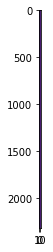

In [78]:
import numpy as np
import matplotlib.pyplot as plt


# random example
plt.imshow(data_results);
# plt.colorbar()
# plt.show()

In [79]:
df = data_results.groupby('cluster').mean()
x = data_results['sentiment']
y= data_results['cluster']
#df = data_results.groupby('cluster').mean()

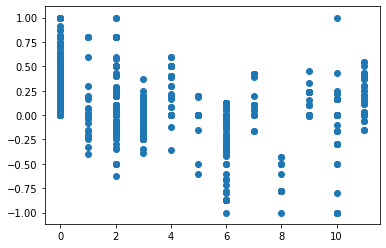

In [81]:
plt.scatter(y,x)

# CREATE A BUBBLE / HEAT 

# USE SENTIMENT OR SUBJECTIVITY AS BUBBLE SIZE

# COLOR BY CLUSTER

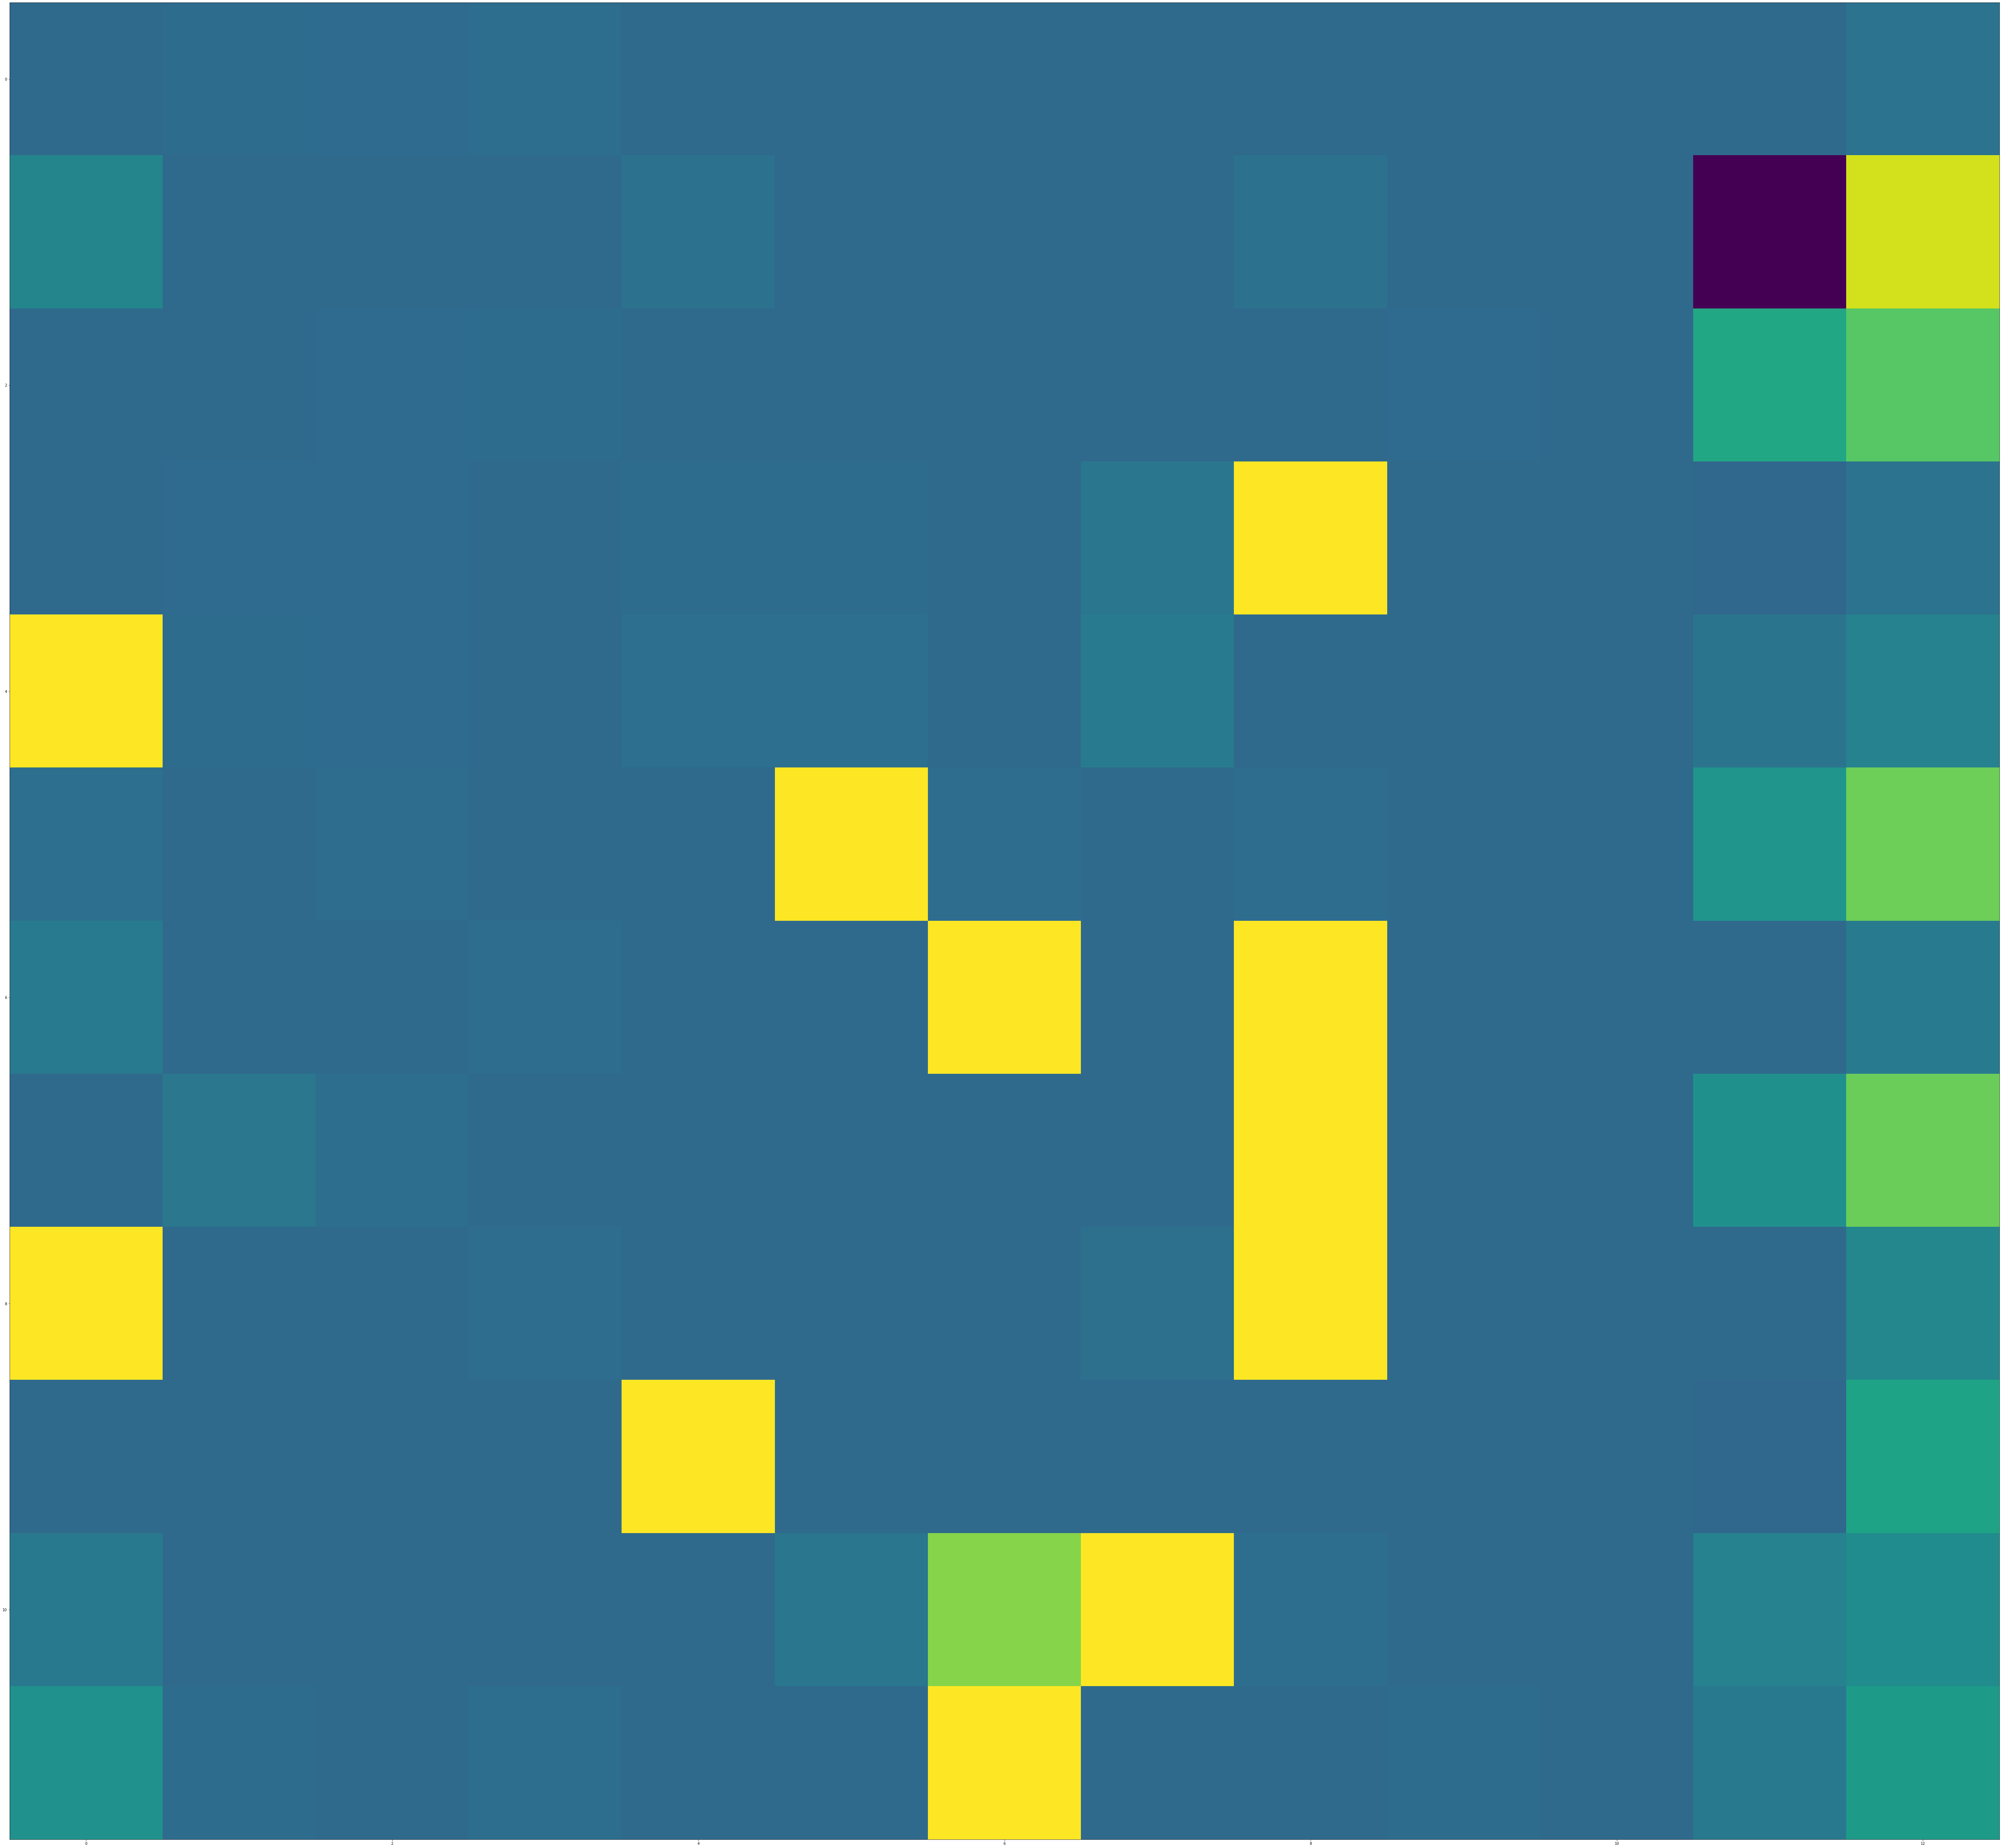

In [40]:
# Still hard to see
plt.figure(figsize=(100,100))
# plt.imshow(data_results)
plt.imshow(df)


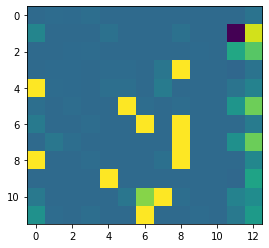

In [43]:
plt.imshow(df)


In [ ]:
# MAKE ANOTHER DATAFRAME WITH NRC 

    #JOY, ANGER, 
    
    # IF WE ARE USING NRC IN OUR FINAL DF WE MUST HAVE A COMPOSITE SCORE
    
    # THE TWEETS HAVE MULTIPLE WORDS AND / OR SCORE IN MULTIPLE CATEGORIES
    
    # 

In [ ]:
# Is there better features that will evaluate the clustering data? 

    # What features? 
    # Scores over binary
    # 

In [41]:
# ONCE THE K-MEAN ANALYSIS HAS BEEN PERFORMED, INTRODUCE DECISION TREE

# DECISION TREE